# Kiva Crowdfunding - Understanding Borrowers and Poverty Levels

Kiva is an online crowdfunding platform to extend financial services to poor and financially excluded people around the world. More information can be found at https://www.kiva.org/.

The objective of this notebook is to help Kiva to better understand their borrowers and build more localized models to estimate the poverty levels in the regions where Kiva has active loans.

*This is a work in progress. Please check back for updates.*

## Contents:
* [Quick EDA of Available Data](#eda)
    * [Kiva Loans](#kiva_loans_eda)
    * [Multi-dimensional Poverty Index (MPI) ](#mpi_eda)
        * [Latitude and Longitude Errors Investigation](#mpi_lat_long_errors)
        * [MPI by Region](#mpi_by_region)
* [Combining Kiva Loan Data with MPI](#combining_loan_mpi)
    * [Data Preprocessing](#preprocessing)
    * [Analysis](#analysis)
* [Next Steps](#next_steps)

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
py.init_notebook_mode(connected=True)
import seaborn as sns

%matplotlib inline

sns.set(rc={"figure.figsize": (20,10), "axes.titlesize" : 16, "axes.labelsize" : 12}, 
        palette=sns.cubehelix_palette(20, reverse=True))

import warnings
warnings.filterwarnings('ignore')

In [290]:
#kiva_loans_df = pd.read_csv("../input/kiva_loans.csv")
#kiva_mpi_locations_df = pd.read_csv("../input/kiva_mpi_region_locations.csv")
#loan_theme_ids_df = pd.read_csv("../input/loan_theme_ids.csv")
#loan_themes_by_region_df = pd.read_csv("../input/loan_themes_by_region.csv")
kiva_loans_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/kiva_loans.csv")
kiva_mpi_locations_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/kiva_mpi_region_locations.csv")
loan_theme_ids_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/loan_theme_ids.csv")
loan_themes_by_region_df = pd.read_csv("../input/data-science-for-good-kiva-crowdfunding/loan_themes_by_region.csv")

## Quick EDA of Available Data <a name="eda"/>

### Kiva Loans <a name="kiva_loans_eda"/>

First let us get a quick idea of where the loan requests are mostly coming from.

Text(0.5,1,'Distribution of Kiva Loans by Country')

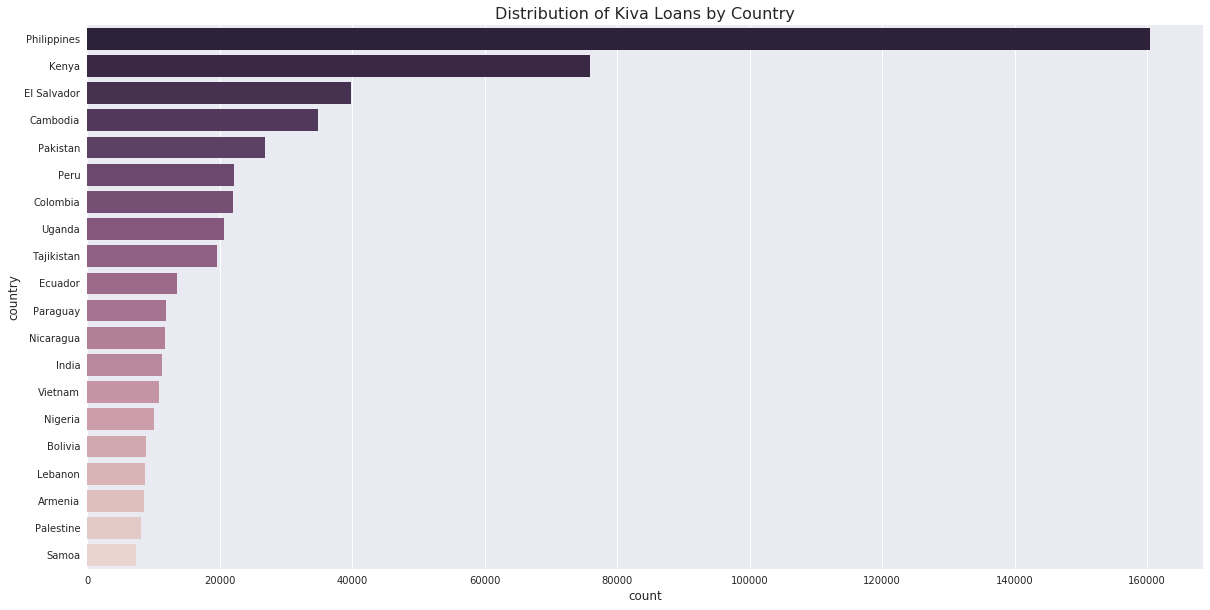

In [291]:
# Plot loans per country
sns.countplot(y="country", data=kiva_loans_df, 
              order=kiva_loans_df.country.value_counts().iloc[:20].index).set_title("Distribution of Kiva Loans by Country")

- The Phillipines has by far the most number of Kiva loan requests.

Text(0.5,1,'Distribution of Kiva Loans by Region')

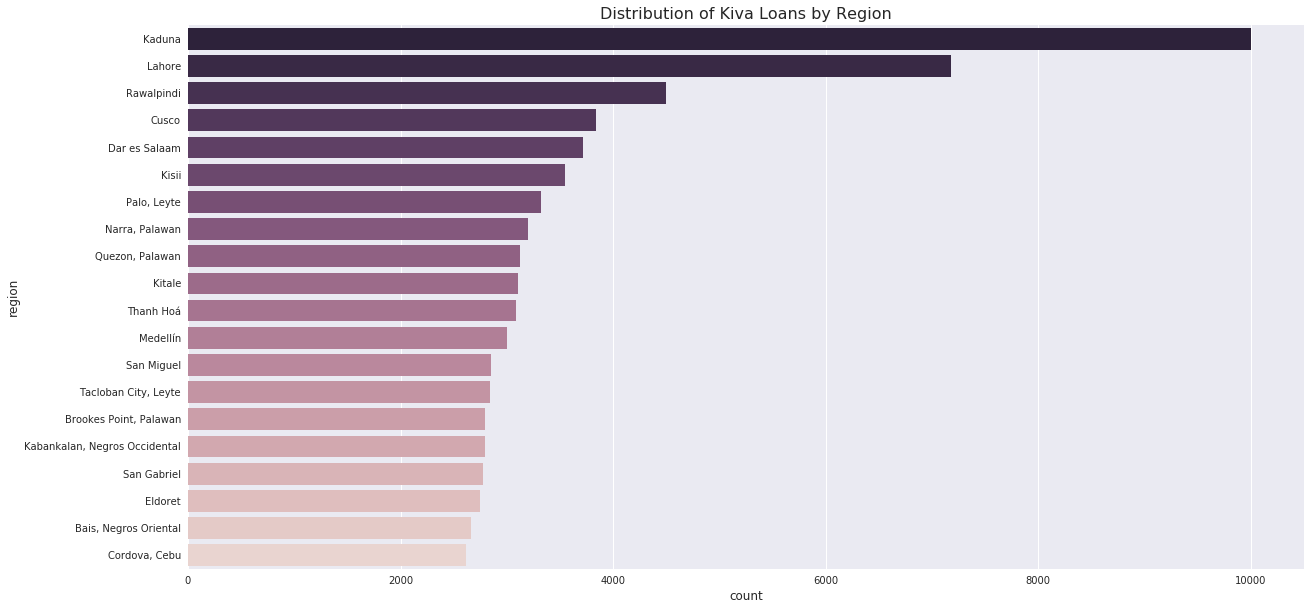

In [292]:
# Plot loans per region
sns.countplot(y="region", data=kiva_loans_df, 
              order=kiva_loans_df.region.value_counts().iloc[:20].index).set_title("Distribution of Kiva Loans by Region")

- When looking at the number of requests by region, Kaduna is at the top of the list.

Let us plot the total number loan requests on a map to better visualise where the Kiva loan requests are mostly coming from.

In [293]:
countries_number_loans = kiva_loans_df.groupby('country').count()['loan_amount'].sort_values(ascending = False)
data = [dict(
        type='choropleth',
        locations= countries_number_loans.index,
        locationmode='country names',
        z=countries_number_loans.values,
        text=countries_number_loans.index,
        colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='# Loans'),
)]
layout = dict(title = 'Number of Loans Requested by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='loans-total-map')

Let us have a look at whether is a similar case for the total loan amount requested.

In [294]:
countries_loan_amount = kiva_loans_df.groupby('country').sum()['loan_amount'].sort_values(ascending = False)
data = [dict(
        type='choropleth',
        locations= countries_loan_amount.index,
        locationmode='country names',
        z=countries_loan_amount.values,
        text=countries_loan_amount.index,
        colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
        marker=dict(line=dict(width=0.7)),
        colorbar=dict(autotick=False, tickprefix='', title='Loan Amount'),
)]
layout = dict(title = 'Total Loan Amount Requested by Country', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='loans-total-map')

Now a quick look at the distribution of loan requests per sector.

Text(0.5,1,'Distribution of Loans by Sector')

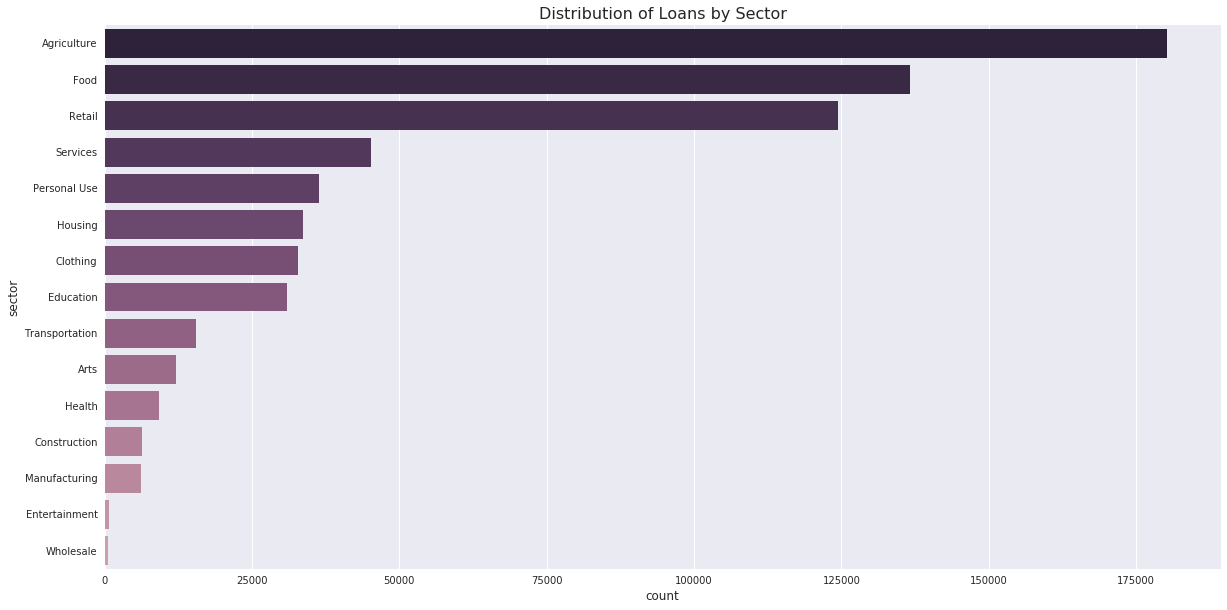

In [295]:
# Plot loans per sector
sns.countplot(y="sector", data=kiva_loans_df, 
              order=kiva_loans_df.sector.value_counts().iloc[:20].index).set_title("Distribution of Loans by Sector")

- Agriculture tops the list of loan requests by sector, followed by Food and Retail.

Let us look at the distribution of loan amounts. Note, the initial plot was unreadable due to an outlier so it has been truncated as a first step before plotting.

In [296]:
# Truncate outliers
percentile_99 = np.percentile(kiva_loans_df.loan_amount.values, 99)
kiva_loans_df['loan_amount_trunc'] = kiva_loans_df['loan_amount'].copy()
kiva_loans_df.loc[kiva_loans_df['loan_amount_trunc'] > percentile_99, 'loan_amount_trunc'] = percentile_99

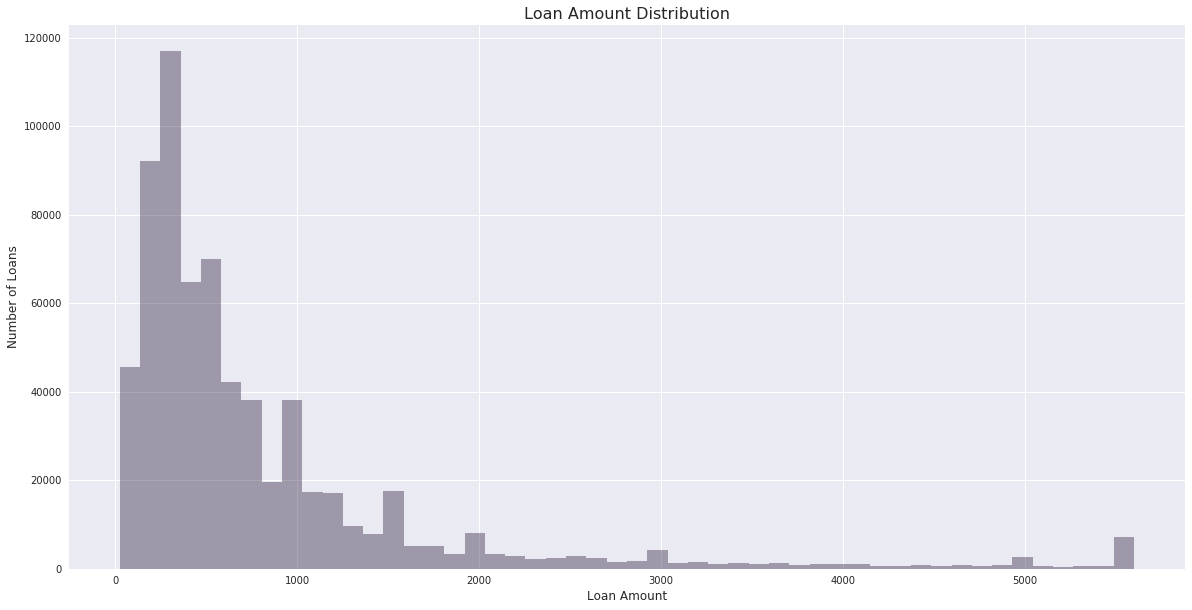

In [297]:
# Plot loan amount histogram
sns.distplot(kiva_loans_df.loan_amount_trunc.values, kde=False)
plt.title("Loan Amount Distribution")
plt.xlabel('Loan Amount')
plt.ylabel('Number of Loans')
plt.show()

- The loan amounts are relatively low, most under 1000 USD.

Let us visualise the repayment term and interval of the Kiva loans.

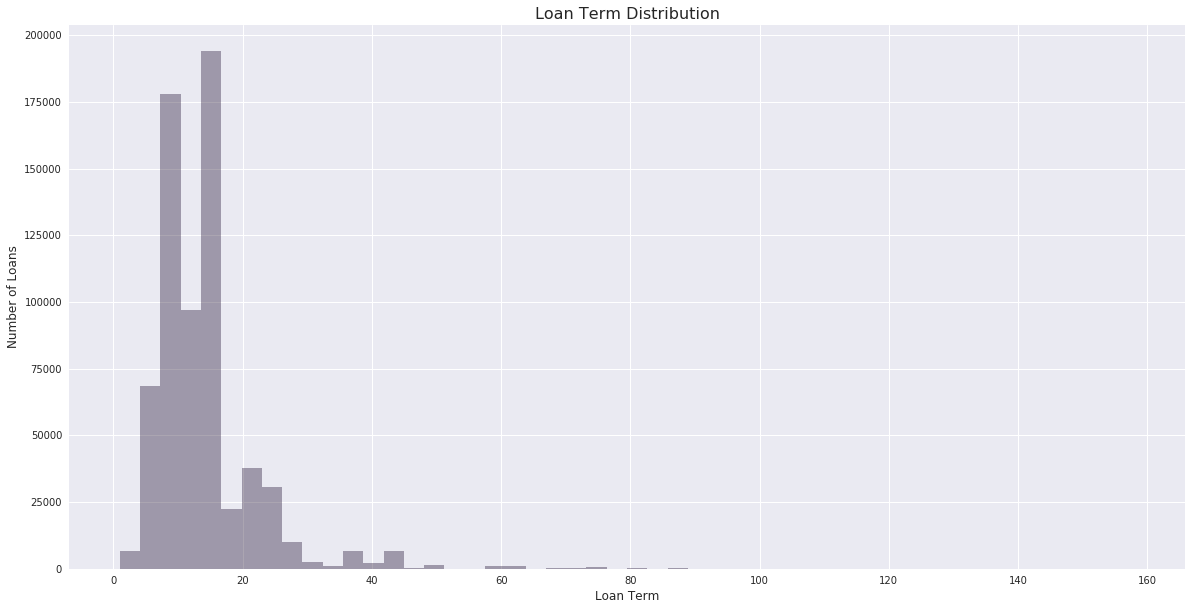

In [298]:
# Plot repayent term histogram
sns.distplot(kiva_loans_df.term_in_months.values, kde=False)
plt.title("Loan Term Distribution")
plt.xlabel('Loan Term')
plt.ylabel('Number of Loans')
plt.show()

- The loan terms are mostly between 6 and 30 mnths.

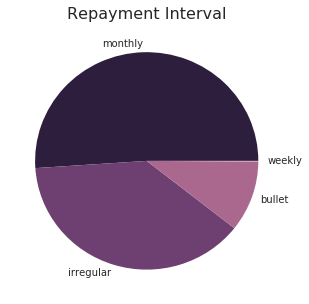

In [299]:
# Plot repayment interval of loans
with sns.cubehelix_palette(5, reverse=True):
    plt.figure(figsize=(5,5))
    plt.title("Repayment Interval")
    kiva_loans_df.repayment_interval.value_counts().T.plot.pie(labeldistance=1.08)
    plt.ylabel('')

- Most loans are repaid monthly or irregularly. 

### Multi-dimensional Poverty Index (MPI)  <a name="mpi_eda"/>

The MPI identifies deprivations across the three dimensions and shows the number of people who are multidimensionally poor (suffering deprivations in 33% or more of the weighted indicators). 

More information at http://hdr.undp.org/en/content/multidimensional-poverty-index-mpi.

Firstly, a quick plot to visualise the MPI data on the world map.

In [300]:
data = [ dict(
        type = 'scattergeo',
        lon = kiva_mpi_locations_df['lon'],
        lat = kiva_mpi_locations_df['lat'],
        text = kiva_mpi_locations_df['LocationName'],
        drawmapboundary = dict(fill_color = '#A6CAE0', linewidth = 0.1),
        mode = 'markers',
        marker = dict(
            size = 6,
            opacity = 0.9,
            symbol = 'circle',
            line = dict(width = 1, color = 'rgba(80, 80, 80)'),
            colorscale = [[0,'rgb(216, 191, 216)'],[1,'rgb(75, 0, 130)']],
            cmin = 0,
            color = kiva_mpi_locations_df['MPI'],
            cmax = kiva_mpi_locations_df['MPI'].max(),
            colorbar=dict(title="MPI")
        ))]
layout = dict(title = 'MPI by Region', 
        geo = dict(
            showframe = False, 
            showcoastlines = True, 
            projection = dict(type = 'Mercator')
        ))
fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='mpi-region-map')

It was pointed out to me that some regions are plotted in the wrong place on the map! We can easily confirm this is the case by, for example, looking at the point in southern Australia, which when hovering over it indicates it is Tanzania!

### Latitude and Longitude Errors Investigation  <a name="mpi_lat_long_errors"/>

Let us do a quick investigation of the errors.

#### Crossvalidation with LoanThemes Dataset

In [301]:
#eliminate regions missing important data
print("Original Regions dataset: ", kiva_mpi_locations_df.shape)
kiva_mpi_lat_long = kiva_mpi_locations_df[['LocationName', 'region', 'lat', 'lon', 'MPI']]
kiva_mpi_lat_long = kiva_mpi_lat_long.dropna()
print("Cleaned Regions dataset: ", kiva_mpi_lat_long.shape)

# Filter relevant columns from loan_themes_by_region_df
loan_themes_lat_long = loan_themes_by_region_df[['mpi_region', 'lat', 'lon']]
loan_themes_lat_long.rename(columns={'mpi_region':'LocationName', 'lat':'lat2', 'lon':'lon2'}, inplace=True)
loan_themes_lat_long.shape

# Drop duplicates
loan_themes_lat_long.drop_duplicates(subset=['LocationName'], inplace=True)

# merge
kiva_mpi_merged = pd.merge(kiva_mpi_lat_long, loan_themes_lat_long, how='left')
print("Joined Regions dataset: ", kiva_mpi_merged.shape)

# How many entries have not been assigned a new lat,long?
print("Number of regions without a match in the Kiva Loan Themes dataset: ", sum(pd.isnull(kiva_mpi_merged['lat2'])))

Original Regions dataset:  (2772, 9)
Cleaned Regions dataset:  (892, 5)
Joined Regions dataset:  (892, 7)
Number of regions without a match in the Kiva Loan Themes dataset:  558


Unfortunately there are not many matches by region between the loan_themes_by_region_df and the kiva_mpi_locations_df dattasets. (558 out of 892)

Let us try with another (external) dataset, although it may be even harder to get matches if the Kiva dataset hasn't used "standard" region names.

#### Crossvalidation with External Dataset

In [303]:
# Read in the external dataset
world_cities_df = pd.read_csv("../input/simplemaps-worldcities-basic.csv")

# Drop some irrelevant columns and rename others
iso3_location_df = world_cities_df[['iso3', 'province', 'lat', 'lng']]
iso3_location_df.rename(columns={'iso3': 'ISO', 'province': 'region', 'lat' : 'worldcities_lat', 'lng' : 'worldcities_lng'}, inplace=True)

# Convert the columns to the same case for the merge
kiva_mpi_merged['region'] = kiva_mpi_merged['region'].str.lower()
iso3_location_df['region'] = iso3_location_df['region'].str.lower()

# Drop duplicates
iso3_location_df.drop_duplicates(subset=['region'], inplace=True)

kiva_mpi_merged= pd.merge(kiva_mpi_merged, iso3_location_df, how='left')
print("Joined Regions dataset: ", kiva_mpi_merged.shape)

# How many entries have not been assigned a new lat,long?
print("Number of regions without a match in the external dataset: ", sum(pd.isnull(kiva_mpi_merged['worldcities_lat'])))

Joined Regions dataset:  (892, 10)
Number of regions without a match in the external dataset:  458


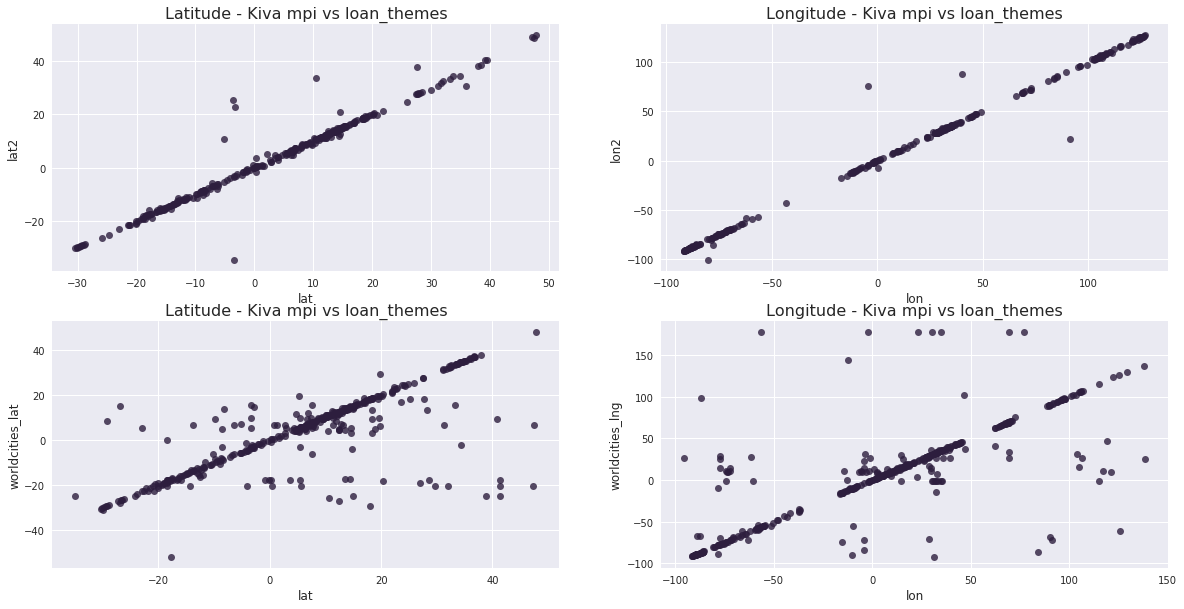

In [304]:
plt.subplot(221).set_title("Latitude - Kiva mpi vs loan_themes")
sns.regplot(x = kiva_mpi_merged.lat, y = kiva_mpi_merged.lat2, fit_reg=False)
    
plt.subplot(222).set_title("Longitude - Kiva mpi vs loan_themes")
sns.regplot(x = kiva_mpi_merged.lon, y = kiva_mpi_merged.lon2, fit_reg=False)

plt.subplot(223).set_title("Latitude - Kiva mpi vs loan_themes")
sns.regplot(x = kiva_mpi_merged.lat, y = kiva_mpi_merged.worldcities_lat, fit_reg=False)
    
plt.subplot(224).set_title("Longitude - Kiva mpi vs loan_themes")
sns.regplot(x = kiva_mpi_merged.lon, y = kiva_mpi_merged.worldcities_lng, fit_reg=False)

It is obvious from the plots that there are a few errors in the latitude and longitude values. However, as the values are actually only used in a visualisation to get a picture of what the MPI distribution looks like, let us ignore this for now. Latitude and Longitude are currently not used anywhere else in this notebook. If we have to use them later on we may have to do more research to get a reliable source of latitude and longitude values and do some data cleaning.

### MPI by World Region  <a name="mpi_by_region"/>

In [261]:
print(kiva_mpi_locations_df.shape)
kiva_mpi_locations_df.sample(5)

(2772, 9)


LocationName  ISO             country     region  \
199   Sangha, Congo, Republic of  COG  Congo, Republic of     Sangha   
539        Bongolava, Madagascar  MDG          Madagascar  Bongolava   
2465                         NaN  NaN                 NaN        NaN   
252                  Giza, Egypt  EGY               Egypt       Giza   
1721                         NaN  NaN                 NaN        NaN   

            world_region    MPI                        geo        lat  \
199   Sub-Saharan Africa  0.285    (1.4662328, 15.4068079)   1.466233   
539   Sub-Saharan Africa  0.319  (-18.6336864, 46.0563212) -18.633686   
2465                 NaN    NaN           (1000.0, 1000.0)        NaN   
252          Arab States  0.018   (30.0130557, 31.2088526)  30.013056   
1721                 NaN    NaN           (1000.0, 1000.0)        NaN   

            lon  
199   15.406808  
539   46.056321  
2465        NaN  
252   31.208853  
1721        NaN

Looking at the MPI dataset we notice that there are a lot of missing values to deal with. The main features we are interested in are LocationName, country, region and MPI so we will drop all the entries that don't have these values.
(Note: LocationName is available wherever country and region are available so we will keep and use this column too.)

In [262]:
print("Original MPI dataset: ", kiva_mpi_locations_df.shape)
region_mpi_df = kiva_mpi_locations_df[['world_region', 'LocationName', 'country','region', 'MPI']]
region_mpi_df = region_mpi_df.dropna()
print("Cleaned MPI dataset: ", region_mpi_df.shape)

Original MPI dataset:  (2772, 9)
Cleaned MPI dataset:  (984, 5)


Unfortunately a lot of data was discarded at this step, however we will proceed with it and may have to source region-MPI mappings from other external datasets later on.

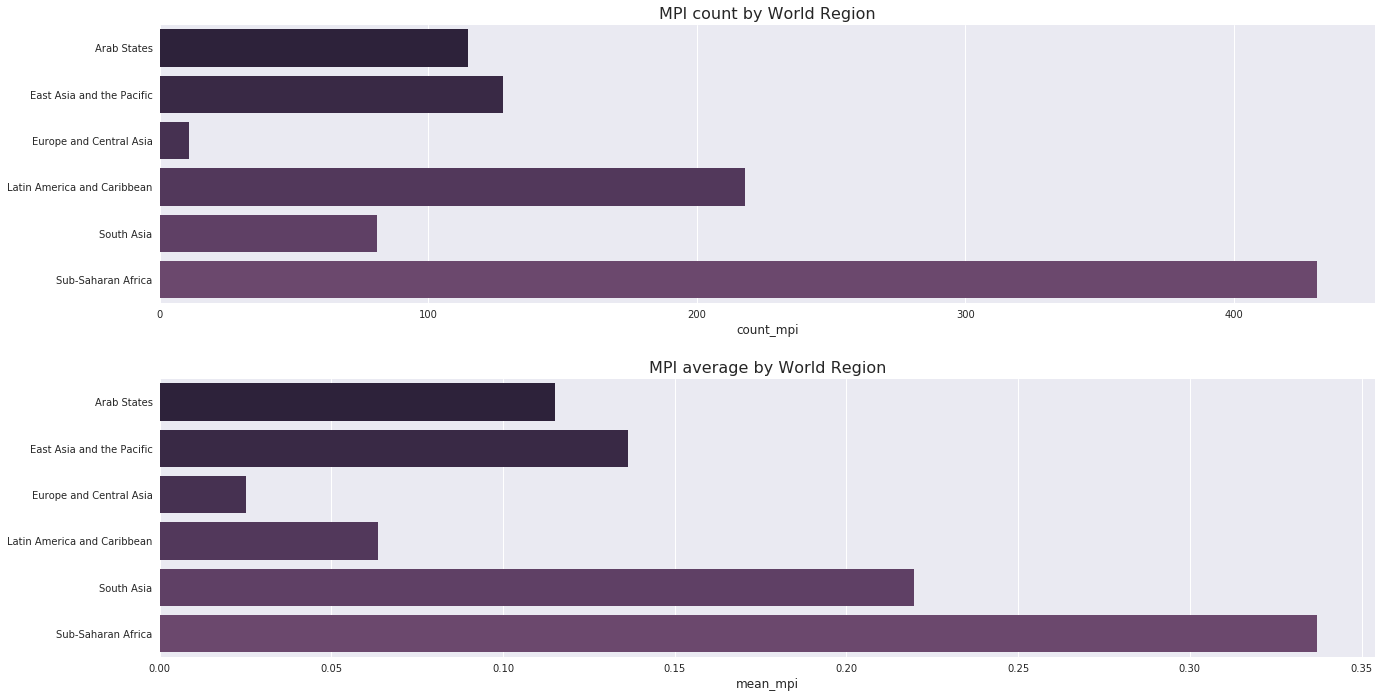

In [310]:
# Plot MPI by World Region
plt.subplot(211).set_title("MPI count by World Region")
world_region_mpi_count_df = region_mpi_df.groupby(['world_region'])['MPI'].count().reset_index(name='count_mpi')
sns.barplot(world_region_mpi_count_df.count_mpi, world_region_mpi_count_df.world_region)
plt.ylabel('')

plt.subplot(212).set_title("MPI average by World Region")
world_region_mpi_mean_df = region_mpi_df.groupby(['world_region'])['MPI'].mean().reset_index(name='mean_mpi')
sns.barplot(world_region_mpi_mean_df.mean_mpi, world_region_mpi_mean_df.world_region)
plt.ylabel('')

plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=2.0, rect=[0, 0, 0.95, 0.95])
plt.savefig('world_region_mpi.png');

- This is mostly as we would expect it. Sub-Saharan Africa has the highest number of MPI reports as well as the higest average MPI of all world regions.
It is interesting to note that Latin America and the Caribbean have the second highest number of MPI reports but the second lowest average MPI. The opposite is true for South Asia, with a low numer of MPI reports but high average MPI.

## Combining Kiva Loan Data with MPI  <a name="combining_loan_mpi"/>

In this section we will join the Kiva Loan data with the MPI dataset to try and get an understanding of the relationship between loan requests and MPI.

### Data Preprocessing <a name="preprocessing"/>

We will do the same removal of entries with no country or region for the Kiva Loans dataset. We will also drop a few less relevant features and then join the MPI information to the Loan information.

In [16]:
print("Original Kiva Loans dataset: ", kiva_loans_df.shape)
kiva_loans_mpi_df = kiva_loans_df.dropna(subset = ['country','region'])
#kiva_loans_mpi_df = kiva_loans_mpi_df.drop(columns=['id', 'use', 'country_code', 'partner_id', 'lender_count'])
print("Cleaned Kiva Loans dataset: ", kiva_loans_mpi_df.shape)

kiva_loans_mpi_df= pd.merge(kiva_loans_mpi_df, region_mpi_df, how='left')
kiva_loans_mpi_df.sample(5)

Original Kiva Loans dataset:  (671205, 21)
Cleaned Kiva Loans dataset:  (614405, 21)


id  funded_amount  loan_amount                   activity  \
161859   834402          250.0        250.0    Personal Products Sales   
461913  1171687          750.0        750.0     Higher education costs   
38638    695485          925.0        925.0             Clothing Sales   
324144  1012123          400.0        400.0                    Farming   
318368  1005748          850.0        850.0  Personal Medical Expenses   

             sector                                                use  \
161859       Retail  to buy merchandise like beauty products, cloth...   
461913    Education                     to pay for her education fees.   
38638      Clothing      to purchase four bales of clothing for resale   
324144  Agriculture   to buy rice seed and to cover business expenses.   
318368       Health                      to solve her dental problems.   

       country_code      country                                    region  \
161859           PH  Philippines                            Bacoor, Cavite   
461913           PY     Paraguay                           Ciudad del Este   
38638            KE        Kenya                                   Kisauni   
324144           KH     Cambodia  Battambang province, Thmor Koul district   
318368           AM      Armenia                                     Sevan   

       currency ...  term_in_months lender_count  \
161859      PHP ...             6.0            9   
461913      PYG ...            14.0           29   
38638       KES ...            10.0           32   
324144      KHR ...            14.0           14   
318368      AMD ...            20.0           34   

                                                     tags borrower_genders  \
161859                                                NaN           female   
461913                                         #Schooling           female   
38638                     user_favorite, #Woman Owned Biz           female   
324144         #Elderly, #Single Parent, #Vegan, #Widowed     female, male   
318368  #First Loan, #Health and Sanitation, #Inspirin...           female   

        repayment_interval        date loan_amount_trunc world_region  \
161859           irregular  2015-01-30             250.0          NaN   
461913             monthly  2016-10-20             750.0          NaN   
38638            irregular  2014-04-09             925.0          NaN   
324144             monthly  2016-01-22             400.0          NaN   
318368             monthly  2016-01-08             850.0          NaN   

       LocationName MPI  
161859          NaN NaN  
461913          NaN NaN  
38638           NaN NaN  
324144          NaN NaN  
318368          NaN NaN  

[5 rows x 24 columns]

It looks like there were not many matches of country and region and we have quite a few missing MPI values. We will have to drop these entries as well. Again, note, we are losing a lot of data here but we will proceed for now with the given datasets and later on explore other data sets that may provide better mappings.

In [17]:
print("Original Kiva MPI Loans dataset: ", kiva_loans_df.shape)
kiva_loans_mpi_df = kiva_loans_mpi_df.dropna(subset=['MPI'])
print("Cleaned Kiva MPI dataset: ", kiva_loans_mpi_df.shape)

Original Kiva MPI Loans dataset:  (671205, 21)
Cleaned Kiva MPI dataset:  (50955, 24)


### Analysis <a name="analysis"/>

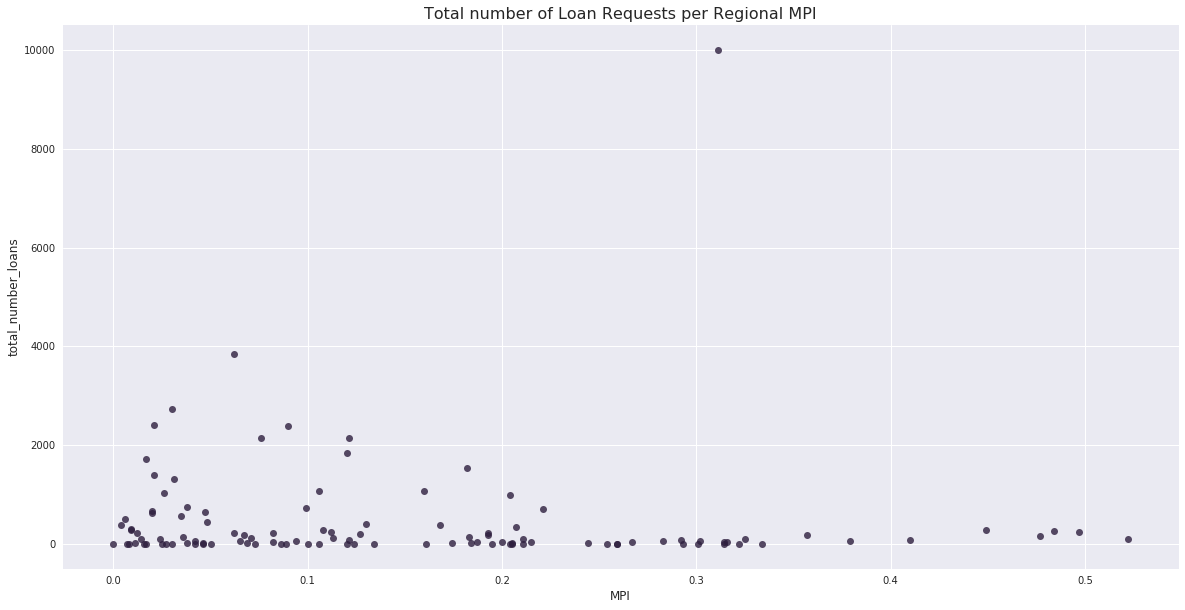

In [18]:
# Scatter plot of number of loans per MPI
total_loans_mpi_df = kiva_loans_mpi_df.groupby(['country','region','MPI'])['loan_amount'].count().reset_index(name='total_number_loans')
total_loans_mpi_df.sample(5)
sns.regplot(x = total_loans_mpi_df.MPI, y = total_loans_mpi_df.total_number_loans, fit_reg=False)
plt.title("Total number of Loan Requests per Regional MPI")
plt.show()

- The total number of loan requests to Kiva is actually higher in the regions with a lower MPI (ie: regions that have less poverty, although note as I understand it they do have substantial poverty to even receive a MPI score). 
- There is also one outlier with an extremely high total number of requests.

In [19]:
# Examine outliers
percentile_95_df = total_loans_mpi_df[total_loans_mpi_df.total_number_loans > total_loans_mpi_df.total_number_loans.quantile(.95)]
percentile_95_df.sort_values('total_number_loans', ascending=False).head(10)

country      region    MPI  total_number_loans
73       Nigeria      Kaduna  0.311               10000
79          Peru       Cusco  0.062                3841
16   El Salvador  San Miguel  0.030                2737
68     Nicaragua     Managua  0.021                2405
26     Guatemala      Solola  0.090                2383
101       Uganda     Kampala  0.076                2149

One thing to note here is that we don't see the regions of the Philippines listed among the top regions requesting loans, although it was our top country for loan requests (see Quick EDA of Kiva Loans). One reason for this may be that the Philippines is broken down into many more, smaller regions than some of the countries/regions we see listed in this case. Another reason may be that we have dropped it as it didn't have a MPI mapping. Lets check.

In [20]:
# Regions per country
regions_per_country_df = kiva_loans_mpi_df.groupby(['country']).size().reset_index(name='region_count')
regions_per_country_df.sort_values('region_count', ascending=False).head(5)

country  region_count
2      Cambodia         10781
16      Nigeria         10000
15    Nicaragua          8764
18         Peru          5148
4   El Salvador          3436

In [21]:
# Philippines
print(kiva_loans_mpi_df.loc[kiva_loans_mpi_df['country'] == 'Philippines'])

Empty DataFrame
Columns: [id, funded_amount, loan_amount, activity, sector, use, country_code, country, region, currency, partner_id, posted_time, disbursed_time, funded_time, term_in_months, lender_count, tags, borrower_genders, repayment_interval, date, loan_amount_trunc, world_region, LocationName, MPI]
Index: []

[0 rows x 24 columns]


Theory two is correct, we have lost that data. We will proceed for now but notice we are seeing a stronger need to use some external data with better mappings.

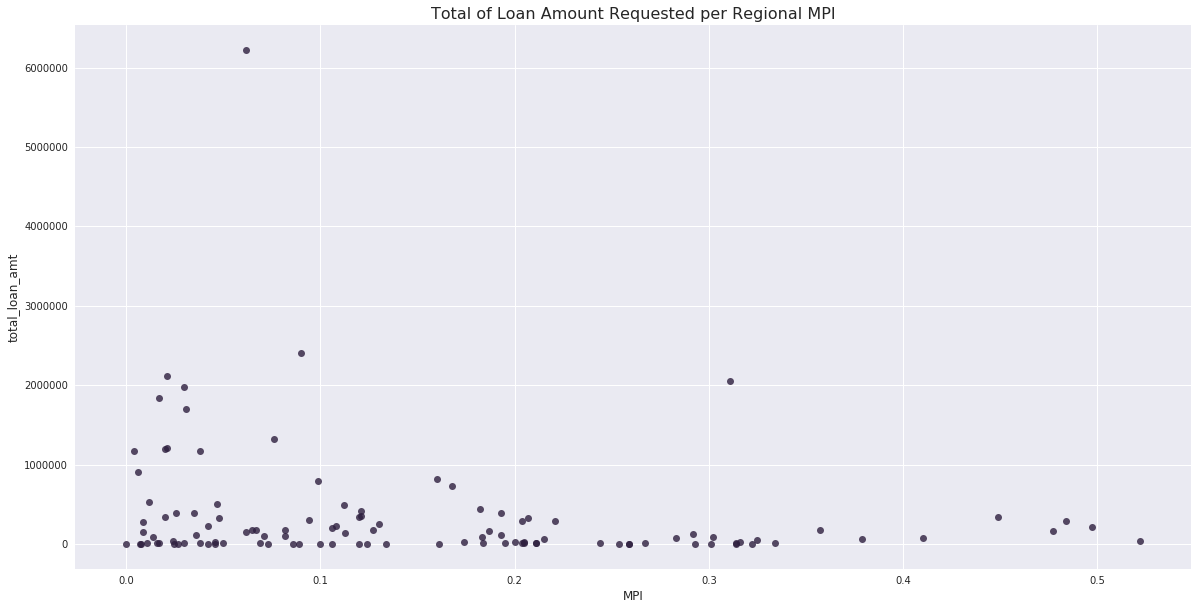

In [22]:
# Scatter plot of total loan amount per MPI
total_loan_amt_df = kiva_loans_mpi_df.groupby(['country','region','MPI'])['loan_amount'].sum().reset_index(name='total_loan_amt')
sns.regplot(x = total_loan_amt_df.MPI, y = total_loan_amt_df['total_loan_amt'], fit_reg = False)
plt.title("Total of Loan Amount Requested per Regional MPI")
plt.show()

In [23]:
# Examine outliers
percentile_95_df = total_loan_amt_df[total_loan_amt_df.total_loan_amt > total_loan_amt_df.total_loan_amt.quantile(.95)]
percentile_95_df.sort_values('total_loan_amt', ascending=False).head(10)

country      region    MPI  total_loan_amt
79         Peru       Cusco  0.062       6222075.0
26    Guatemala      Solola  0.090       2406175.0
68    Nicaragua     Managua  0.021       2117975.0
73      Nigeria      Kaduna  0.311       2048900.0
16  El Salvador  San Miguel  0.030       1973650.0
69    Nicaragua      Masaya  0.017       1833650.0

- Total loan amount exhibits a similar trend to total number of loan requests, there are quite a few higher amount requests in the regions with a lower MPI.

The trend is interesting as one would have expected the opposite - countries with higher MPI would request more loans. A possible explanation for the opposite may be that as MPI increases, the ability of these people to even request loans through Kiva decreases. For example, due to lack of knowledge about loans and the application process, lack of tools to apply for the loan in the first place, etc.

What may be important is that the people from high MPI regions who do request funds get them. Let us plot the percentage of funded loan amount according to regional MPI.

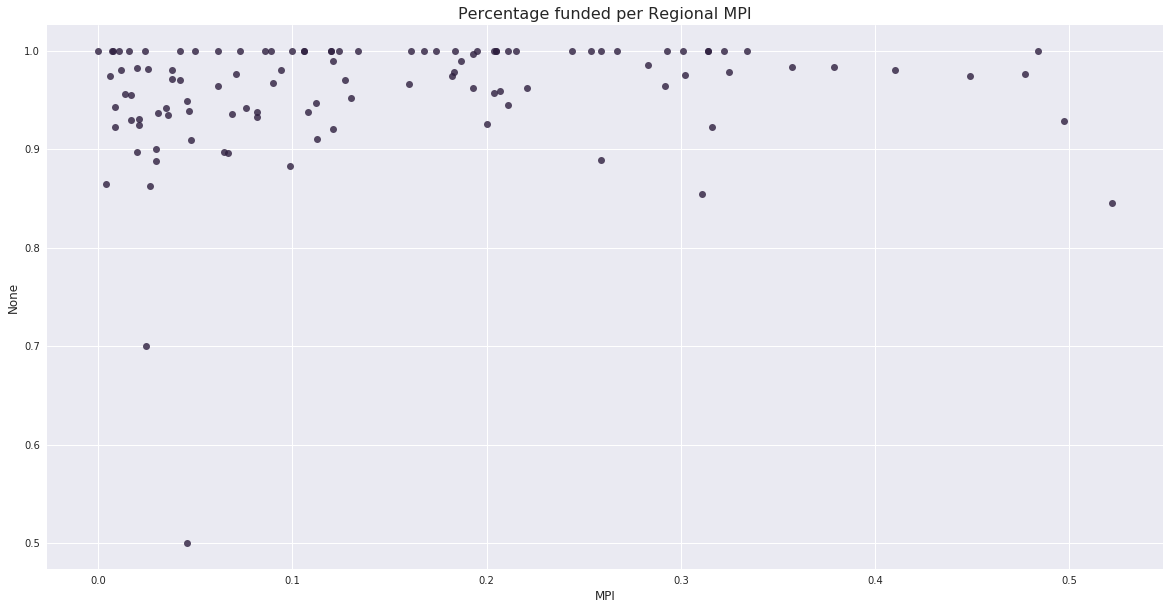

In [24]:
# Scatter plot of total loan amount per MPI
total_funded_amt_df = kiva_loans_mpi_df.groupby(['country','region','MPI'])['funded_amount'].sum().reset_index(name='total_funded_amt')
total_loan_amt_df= pd.merge(total_loan_amt_df, total_funded_amt_df, how='left')
sns.regplot(x = total_loan_amt_df.MPI, y = total_loan_amt_df['total_funded_amt']/total_loan_amt_df['total_loan_amt'], fit_reg = False)
plt.title("Percentage funded per Regional MPI")
plt.show()

It is great to see that so many loans have been fully funded! However, it looks like there is currently no strong relationship between regional MPI and the probability of a loan funded.

## Next Steps  <a name="eda"/>

- Investigate borrower gender 
- Start incorporating some external data to get better mappings of MPI to Kiva Loans
- Investigate MPI per sector, activity, repayment type
- Model building

*To be continued.*